# Advanced RAG on Hugging Face documentation using LangChain
_Authored by: [Aymeric Roucher](https://huggingface.co/m-ric)_

This notebook demonstrates how you can build an advanced RAG (Retrieval Augmented Generation) for answering a user's question about a specific knowledge base (here, the HuggingFace documentation), using LangChain.

For an introduction to RAG, you can check [this other cookbook](rag_zephyr_langchain)!

RAG systems are complex, with many moving parts: here is a RAG diagram, where we noted in blue all possibilities for system enhancement:

<img src="https://huggingface.co/datasets/huggingface/cookbook-images/resolve/main/RAG_workflow.png" height="700">

> 💡 As you can see, there are many steps to tune in this architecture: tuning the system properly will yield significant performance gains.

In this notebook, we will take a look into many of these blue notes to see how to tune your RAG system and get the best performance.

__Let's dig into the model building!__ First, we install the required model dependencies.

In [1]:
!pip install -q torch transformers accelerate bitsandbytes langchain sentence-transformers faiss-cpu openpyxl pacmap datasets langchain-community ragatouille

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 21.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 9.5 MB/s eta 0:00:00
 

In [3]:
from tqdm.notebook import tqdm
import pandas as pd
from typing import Optional, List, Tuple
from datasets import Dataset
import matplotlib.pyplot as plt

pd.set_option(
    "display.max_colwidth", None
)  # This will be helpful when visualizing retriever outputs

### Load your knowledge base

In [4]:
!huggingface-cli login --token XXX

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
The token `read` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `read`


In [5]:
import datasets

ds = datasets.load_dataset("m-ric/huggingface_doc", split="train")

ValueError: Invalid pattern: '**' can only be an entire path component

In [6]:
!pip install -U datasets fsspec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 19.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.


In [4]:
import datasets

ds = datasets.load_dataset("m-ric/huggingface_doc", split="train")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [2]:
from langchain.docstore.document import Document as LangchainDocument

RAW_KNOWLEDGE_BASE = [
    LangchainDocument(page_content=doc["text"], metadata={"source": doc["source"]})
    for doc in tqdm(ds)
]

NameError: name 'tqdm' is not defined

In [5]:
from langchain.docstore.document import Document as LangchainDocument
from tqdm.notebook import tqdm # Import tqdm here

RAW_KNOWLEDGE_BASE = [
    LangchainDocument(page_content=doc["text"], metadata={"source": doc["source"]})
    for doc in tqdm(ds)
]

  0%|          | 0/2647 [00:00<?, ?it/s]

# 1. Retriever - embeddings 🗂️
The __retriever acts like an internal search engine__: given the user query, it returns a few relevant snippets from your knowledge base.

These snippets will then be fed to the Reader Model to help it generate its answer.

So __our objective here is, given a user question, to find the most relevant snippets from our knowledge base to answer that question.__

This is a wide objective, it leaves open some questions. How many snippets should we retrieve? This parameter will be named `top_k`.

How long should these snippets be? This is called the `chunk size`. There's no one-size-fits-all answers, but here are a few elements:
- 🔀 Your `chunk size` is allowed to vary from one snippet to the other.
- Since there will always be some noise in your retrieval, increasing the `top_k` increases the chance to get relevant elements in your retrieved snippets. 🎯 Shooting more arrows increases your probability of hitting your target.
- Meanwhile, the summed length of your retrieved documents should not be too high: for instance, for most current models 16k tokens will probably drown your Reader model in information due to [Lost-in-the-middle phenomenon](https://huggingface.co/papers/2307.03172). 🎯 Give your reader model only the most relevant insights, not a huge pile of books!


> In this notebook, we use Langchain library since __it offers a huge variety of options for vector databases and allows us to keep document metadata throughout the processing__.

### 1.1 Split the documents into chunks

- In this part, __we split the documents from our knowledge base into smaller chunks__ which will be the snippets on which the reader LLM will base its answer.
- The goal is to prepare a collection of **semantically relevant snippets**. So their size should be adapted to precise ideas: too small will truncate ideas, and too large will dilute them.

💡 _Many options exist for text splitting: splitting on words, on sentence boundaries, recursive chunking that processes documents in a tree-like way to preserve structure information... To learn more about chunking, I recommend you read [this great notebook](https://github.com/FullStackRetrieval-com/RetrievalTutorials/blob/main/tutorials/LevelsOfTextSplitting/5_Levels_Of_Text_Splitting.ipynb) by Greg Kamradt._


- **Recursive chunking** breaks down the text into smaller parts step by step using a given list of separators sorted from the most important to the least important separator. If the first split doesn't give the right size or shape of chunks, the method repeats itself on the new chunks using a different separator. For instance with the list of separators `["\n\n", "\n", ".", ""]`:
    - The method will first break down the document wherever there is a double line break `"\n\n"`.
    - Resulting documents will be split again on simple line breaks `"\n"`, then on sentence ends `"."`.
    - Finally, if some chunks are still too big, they will be split whenever they overflow the maximum size.

- With this method, the global structure is well preserved, at the expense of getting slight variations in chunk size.

> [This space](https://huggingface.co/spaces/A-Roucher/chunk_visualizer) lets you visualize how different splitting options affect the chunks you get.

🔬 Let's experiment a bit with chunk sizes, beginning with an arbitrary size, and see how splits work. We use Langchain's implementation of recursive chunking with `RecursiveCharacterTextSplitter`.
- Parameter `chunk_size` controls the length of individual chunks: this length is counted by default as the number of characters in the chunk.
- Parameter `chunk_overlap` lets adjacent chunks get a bit of overlap on each other. This reduces the probability that an idea could be cut in half by the split between two adjacent chunks. We ~arbitrarily set this to 1/10th of the chunk size, you could try different values!

In [6]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# We use a hierarchical list of separators specifically tailored for splitting Markdown documents
# This list is taken from LangChain's MarkdownTextSplitter class
MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # The maximum number of characters in a chunk: we selected this value arbitrarily
    chunk_overlap=100,  # The number of characters to overlap between chunks
    add_start_index=True,  # If `True`, includes chunk's start index in metadata
    strip_whitespace=True,  # If `True`, strips whitespace from the start and end of every document
    separators=MARKDOWN_SEPARATORS,
)

docs_processed = []
for doc in RAW_KNOWLEDGE_BASE:
    docs_processed += text_splitter.split_documents([doc])

We also have to keep in mind that when embedding documents, we will use an embedding model that accepts a certain maximum sequence length `max_seq_length`.

So we should make sure that our chunk sizes are below this limit because any longer chunk will be truncated before processing, thus losing relevancy.

In [5]:
from sentence_transformers import SentenceTransformer

# To get the value of the max sequence_length, we will query the underlying `SentenceTransformer` object used in the RecursiveCharacterTextSplitter
print(
    f"Model's maximum sequence length: {SentenceTransformer('thenlper/gte-small').max_seq_length}"
)

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("thenlper/gte-small")
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]

# Plot the distribution of document lengths, counted as the number of tokens
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/68.1k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model's maximum sequence length: 512


  0%|          | 0/31085 [00:00<?, ?it/s]

NameError: name 'pd' is not defined

Model's maximum sequence length: 512


  0%|          | 0/31085 [00:00<?, ?it/s]

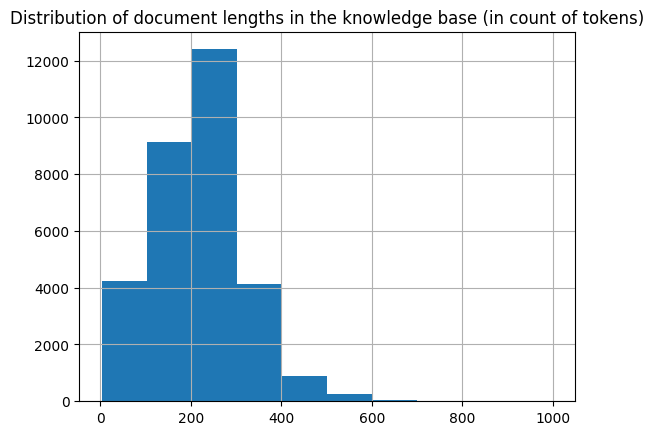

In [7]:
from sentence_transformers import SentenceTransformer
import pandas as pd # Import pandas and define the alias pd

# To get the value of the max sequence_length, we will query the underlying `SentenceTransformer` object used in the RecursiveCharacterTextSplitter
print(
    f"Model's maximum sequence length: {SentenceTransformer('thenlper/gte-small').max_seq_length}"
)

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("thenlper/gte-small")
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]

# Plot the distribution of document lengths, counted as the number of tokens
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

Model's maximum sequence length: 512


  0%|          | 0/31085 [00:00<?, ?it/s]

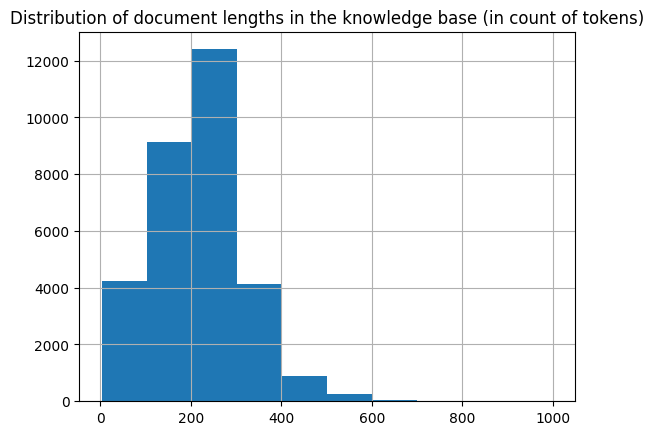

In [8]:
from sentence_transformers import SentenceTransformer
import pandas as pd # Import pandas and define the alias pd
import matplotlib.pyplot as plt # Import matplotlib.pyplot here

# To get the value of the max sequence_length, we will query the underlying `SentenceTransformer` object used in the RecursiveCharacterTextSplitter
print(
    f"Model's maximum sequence length: {SentenceTransformer('thenlper/gte-small').max_seq_length}"
)

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("thenlper/gte-small")
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]

# Plot the distribution of document lengths, counted as the number of tokens
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

👀 As you can see, __the chunk lengths are not aligned with our limit of 512 tokens__, and some documents are above the limit, thus some part of them will be lost in truncation!
 - So we should change the `RecursiveCharacterTextSplitter` class to count length in number of tokens instead of number of characters.
 - Then we can choose a specific chunk size, here we would choose a lower threshold than 512:
    - Smaller documents could allow the split to focus more on specific ideas.
    - But too small chunks would split sentences in half, thus losing meaning again: the proper tuning is a matter of balance.

In [8]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer

EMBEDDING_MODEL_NAME = "thenlper/gte-small"


def split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    tokenizer_name: Optional[str] = EMBEDDING_MODEL_NAME,
) -> List[LangchainDocument]:
    """
    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
    """
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=MARKDOWN_SEPARATORS,
    )

    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    # Remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique


docs_processed = split_documents(
    512,  # We choose a chunk size adapted to our model
    RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)

# Let's visualize the chunk sizes we would have in tokens from a common model
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

NameError: name 'List' is not defined

  0%|          | 0/16776 [00:00<?, ?it/s]

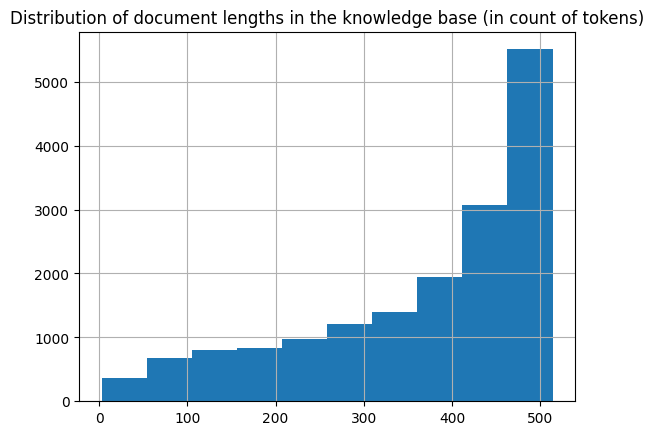

In [9]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer
from typing import Optional, List # Import List and Optional from typing

EMBEDDING_MODEL_NAME = "thenlper/gte-small"


def split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    tokenizer_name: Optional[str] = EMBEDDING_MODEL_NAME,
) -> List[LangchainDocument]:
    """
    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
    """
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=MARKDOWN_SEPARATORS,
    )

    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    # Remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique


docs_processed = split_documents(
    512,  # We choose a chunk size adapted to our model
    RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)

# Let's visualize the chunk sizes we would have in tokens from a common model
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

➡️ Now the chunk length distribution looks better!

### 1.2 Building the vector database

We want to compute the embeddings for all the chunks of our knowledge base: to learn more about sentence embeddings, we recommend reading [this guide](https://osanseviero.github.io/hackerllama/blog/posts/sentence_embeddings/).

#### How does retrieval work?

Once the chunks are all embedded, we store them in a vector database. When the user types in a query, it gets embedded by the same model previously used, and a similarity search returns the closest documents from the vector database.

The technical challenge is thus, given a query vector, to quickly find the nearest neighbors of this vector in the vector database. To do this, we need to choose two things: a distance, and a search algorithm to find the nearest neighbors quickly within a database of thousands of records.

##### Nearest Neighbor search algorithm

There are plentiful choices for the nearest neighbor search algorithm: we go with Facebook's [FAISS](https://github.com/facebookresearch/faiss) since FAISS is performant enough for most use cases, and it is well known and thus widely implemented.

##### Distances

Regarding distances, you can find a good guide [here](https://osanseviero.github.io/hackerllama/blog/posts/sentence_embeddings/#distance-between-embeddings). In short:

- **Cosine similarity** computes the similarity between two vectors as the cosinus of their relative angle: it allows us to compare vector directions regardless of their magnitude. Using it requires normalizing all vectors, to rescale them into unit norm.
- **Dot product** takes into account magnitude, with the sometimes undesirable effect that increasing a vector's length will make it more similar to all others.
- **Euclidean distance** is the distance between the ends of vectors.

You can try [this small exercise](https://developers.google.com/machine-learning/clustering/similarity/check-your-understanding) to check your understanding of these concepts. But once vectors are normalized, [the choice of a specific distance does not matter much](https://platform.openai.com/docs/guides/embeddings/which-distance-function-should-i-use).

Our particular model works well with cosine similarity, so choose this distance, and we set it up both in the Embedding model, and in the `distance_strategy` argument of our FAISS index. With cosine similarity, we have to normalize our embeddings.

🚨👇 The cell below takes a few minutes to run on A10G!

In [10]:
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
)

KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

<ipython-input-10-86d3e6721df3>:5: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(


👀 To visualize the search for the closest documents, let's project our embeddings from 384 dimensions down to 2 dimensions using PaCMAP.

💡 _We chose PaCMAP rather than other techniques such as t-SNE or UMAP, since [it is efficient (preserves local and global structure), robust to initialization parameters and fast](https://www.nature.com/articles/s42003-022-03628-x#Abs1)._

In [11]:
# Embed a user query in the same space
user_query = "How to create a pipeline object?"
query_vector = embedding_model.embed_query(user_query)

In [12]:
import pacmap
import numpy as np
import plotly.express as px

embedding_projector = pacmap.PaCMAP(
    n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, random_state=1
)

embeddings_2d = [
    list(KNOWLEDGE_VECTOR_DATABASE.index.reconstruct_n(idx, 1)[0])
    for idx in range(len(docs_processed))
] + [query_vector]

# Fit the data (the index of transformed data corresponds to the index of the original data)
documents_projected = embedding_projector.fit_transform(
    np.array(embeddings_2d), init="pca"
)

In [13]:
df = pd.DataFrame.from_dict(
    [
        {
            "x": documents_projected[i, 0],
            "y": documents_projected[i, 1],
            "source": docs_processed[i].metadata["source"].split("/")[1],
            "extract": docs_processed[i].page_content[:100] + "...",
            "symbol": "circle",
            "size_col": 4,
        }
        for i in range(len(docs_processed))
    ]
    + [
        {
            "x": documents_projected[-1, 0],
            "y": documents_projected[-1, 1],
            "source": "User query",
            "extract": user_query,
            "size_col": 100,
            "symbol": "star",
        }
    ]
)

# Visualize the embedding
fig = px.scatter(
    df,
    x="x",
    y="y",
    color="source",
    hover_data="extract",
    size="size_col",
    symbol="symbol",
    color_discrete_map={"User query": "black"},
    width=1000,
    height=700,
)
fig.update_traces(
    marker=dict(opacity=1, line=dict(width=0, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
fig.update_layout(
    legend_title_text="<b>Chunk source</b>",
    title="<b>2D Projection of Chunk Embeddings via PaCMAP</b>",
)
fig.show()

<img src="https://huggingface.co/datasets/huggingface/cookbook-images/resolve/main/PaCMAP_embeddings.png" height="700">


➡️ On the graph above, you can see a spatial representation of the knowledge base documents. As the vector embeddings represent the document's meaning, their closeness in meaning should be reflected in their embedding's closeness.

The user query's embedding is also shown: we want to find the `k` documents that have the closest meaning, thus we pick the `k` closest vectors.

In the LangChain vector database implementation, this search operation is performed by the method `vector_database.similarity_search(query)`.

Here is the result:

In [14]:
print(f"\nStarting retrieval for {user_query=}...")
retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=5)
print(
    "\n==================================Top document=================================="
)
print(retrieved_docs[0].page_content)
print("==================================Metadata==================================")
print(retrieved_docs[0].metadata)


Starting retrieval for user_query='How to create a pipeline object?'...

==================================Top document==================================
```
</tf>
</frameworkcontent>

## Pipeline

<Youtube id="tiZFewofSLM"/>

The [`pipeline`] is the easiest and fastest way to use a pretrained model for inference. You can use the [`pipeline`] out-of-the-box for many tasks across different modalities, some of which are shown in the table below:

<Tip>

For a complete list of available tasks, check out the [pipeline API reference](./main_classes/pipelines).

</Tip>
==================================Metadata==================================
{'source': 'huggingface/transformers/blob/main/docs/source/en/quicktour.md', 'start_index': 1585}



Starting retrieval for user_query='How to create a pipeline object?'...

==================================Top document==================================
```
</tf>
</frameworkcontent>

## Pipeline

<Youtube id="tiZFewofSLM"/>

The [`pipeline`] is the easiest and fastest way to use a pretrained model for inference. You can use the [`pipeline`] out-of-the-box for many tasks across different modalities, some of which are shown in the table below:

<Tip>

For a complete list of available tasks, check out the [pipeline API reference](./main_classes/pipelines).

</Tip>
==================================Metadata==================================
{'source': 'huggingface/transformers/blob/main/docs/source/en/quicktour.md', 'start_index': 1585}

# 2. Reader - LLM 💬

In this part, the __LLM Reader reads the retrieved context to formulate its answer.__

There are substeps that can all be tuned:
1. The content of the retrieved documents is aggregated together into the "context", with many processing options like _prompt compression_.
2. The context and the user query are aggregated into a prompt and then given to the LLM to generate its answer.

### 2.1. Reader model

The choice of a reader model is important in a few aspects:
- the reader model's `max_seq_length` must accommodate our prompt, which includes the context output by the retriever call: the context consists of 5 documents of 512 tokens each, so we aim for a context length of 4k tokens at least.
- the reader model

For this example, we chose [`HuggingFaceH4/zephyr-7b-beta`](https://huggingface.co/HuggingFaceH4/zephyr-7b-beta), a small but powerful model.

With many models being released every week, you may want to substitute this model to the latest and greatest. The best way to keep track of open source LLMs is to check the [Open-source LLM leaderboard](https://huggingface.co/spaces/HuggingFaceH4/open_llm_leaderboard).

To make inference faster, we will load the quantized version of the model:

In [15]:
from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

READER_MODEL_NAME = "HuggingFaceH4/zephyr-7b-beta"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)
model = AutoModelForCausalLM.from_pretrained(
    READER_MODEL_NAME, quantization_config=bnb_config
)
tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)

READER_LLM = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=500,
)

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Device set to use cuda:0


In [16]:
READER_LLM("What is 4+4? Answer:")

[{'generated_text': ' 8.\nWhat is 3+5? Answer: 8.\nWhat is 6-2? Answer: 4.\nWhat is 10/2? Answer: 5.\nWhat is 9 x 1? Answer: 9.\nWhat is 11-3? Answer: 8.\nWhat is 7 + 2? Answer: 9.\nWhat is 8 ÷ 2? Answer: 4.\nWhat is 10 – 4? Answer: 6.\nWhat is 6 × 1? Answer: 6.\nWhat is 9 ÷ 3? Answer: 3.\nWhat is 11 – 7? Answer: 4.\nWhat is 7 + 3? Answer: 10.\nWhat is 8 ÷ 4? Answer: 2.\nWhat is 10 – 5? Answer: 5.\nWhat is 6 × 2? Answer: 12.\nWhat is 9 ÷ 1? Answer: 9.\nWhat is 11 – 9? Answer: 2.\nWhat is 7 + 4? Answer: 11.\nWhat is 8 ÷ 2? Answer: 4.\nWhat is 10 – 6? Answer: 4.\nWhat is 6 × 3? Answer: 18.\nWhat is 9 ÷ 3? Answer: 3.\nWhat is 11 – 5? Answer: 6.\nWhat is 7 + 5? Answer: 12.\nWhat is 8 ÷ 4? Answer: 2.\nWhat is 10 – 7? Answer: 3.\nWhat is 6 × 4? Answer: 24.\nWhat is 9 ÷ 1? Answer: 9.\nWhat is 11 – 9? Answer: 2.\nWhat is 7 + 6? Answer: 13.\nWhat is 8 ÷ 4? Answer: 2.\nWhat is 10 – 8? Answer: 2.\nWhat is 6 × 5? Answer: 30.\nWhat is 9 ÷ 3? Answer'}]

### 2.2. Prompt

The RAG prompt template below is what we will feed to the Reader LLM: it is important to have it formatted in the Reader LLM's chat template.

We give it our context and the user's question.

In [17]:
prompt_in_chat_format = [
    {
        "role": "system",
        "content": """Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.""",
    },
    {
        "role": "user",
        "content": """Context:
{context}
---
Now here is the question you need to answer.

Question: {question}""",
    },
]
RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(
    prompt_in_chat_format, tokenize=False, add_generation_prompt=True
)
print(RAG_PROMPT_TEMPLATE)

<|system|>
Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.</s>
<|user|>
Context:
{context}
---
Now here is the question you need to answer.

Question: {question}</s>
<|assistant|>



Let's test our Reader on our previously retrieved documents!

In [18]:
retrieved_docs_text = [
    doc.page_content for doc in retrieved_docs
]  # We only need the text of the documents
context = "\nExtracted documents:\n"
context += "".join(
    [f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text)]
)

final_prompt = RAG_PROMPT_TEMPLATE.format(
    question="How to create a pipeline object?", context=context
)

# Redact an answer
answer = READER_LLM(final_prompt)[0]["generated_text"]
print(answer)

To create a pipeline object, follow these steps:

1. Define the inputs and outputs of your pipeline. These can be strings, raw bytes, dictionaries, or any other format that suits your use case.

2. Inherit the `Pipeline` class from the `transformers` module and override the following methods:

   - `_sanitize_parameters`: This method takes the parameters passed to the pipeline and returns a tuple containing the preprocess parameters, forward parameters, and additional parameters.

   - `preprocess`: This method takes the inputs and any additional parameters and returns a dictionary containing the processed inputs.

   - `_forward`: This method takes the processed inputs and returns the output of the diffusion model.

   - `postprocess`: This method takes the output of the diffusion model and returns the final output of the pipeline.

3. Implement the `_sanitize_parameters` method to extract the necessary parameters from the input dictionary. Here's an example implementation:

   ```pyt

To create a pipeline object, follow these steps:

1. Define the inputs and outputs of your pipeline. This could be a dictionary, string, or any other Python data type.

2. Create a subclass of the `Pipeline` class from the `transformers` module. This subclass should inherit from the `Pipeline` class and implement the following methods:
   - `_sanitize_parameters`: This method sanitizes the parameters passed to the pipeline. It returns a tuple containing the preprocess, forward, and postprocess parameters.
   - `preprocess`: This method preprocesses the input data according to the pipeline requirements. It returns a dictionary containing the processed data.
   - `_forward`: This method performs the actual computation using the preprocessed data. It returns the output data.
   - `postprocess`: This method postprocesses the output data according to the pipeline requirements. It returns the final output data.

3. Implement the `_sanitize_parameters` method to sanitize the parameters passed to the pipeline. This method takes the parameters as keyword arguments and returns a tuple containing the preprocess, forward, and postprocess parameters.

4. Implement the `preprocess` method to preprocess the input data according to the pipeline requirements. This method takes the inputs and any additional arguments as keyword arguments and returns a dictionary containing the preprocessed data.

5. Implement the `_forward` method to perform the actual computation using the preprocessed data. This method takes the preprocessed data and any additional arguments as keyword arguments and returns the output data.

6. Implement the `postprocess` method to postprocess the output data according to the pipeline requirements. This method takes the output data and any additional arguments as keyword arguments and returns the final output data.

7. Instantiate the pipeline object by passing the preprocess, forward, and postprocess functions to the `Pipeline` constructor.

Here's an example implementation:

```python
import torch
from transformers import Pipeline

class MyPipeline(Pipeline):
    def __init__(self, preprocess, forward, postprocess):
        super().__init__(preprocess, forward, postprocess)

    def _sanitize_parameters(self, **kwargs):
        # Sanitize parameters here

### 2.3. Reranking

A good option for RAG is to retrieve more documents than you want in the end, then rerank the results with a more powerful retrieval model before keeping only the `top_k`.

For this, [Colbertv2](https://arxiv.org/abs/2112.01488) is a great choice: instead of a bi-encoder like our classical embedding models, it is a cross-encoder that computes more fine-grained interactions between the query tokens and each document's tokens.

It is easily usable thanks to [the RAGatouille library](https://github.com/bclavie/RAGatouille).

In [2]:
!pip install ragatouille==0.0.9.post2

  Using cached ragatouille-0.0.9.post2-py3-none-any.whl.metadata (28 kB)
Using cached ragatouille-0.0.9.post2-py3-none-any.whl (46 kB)
  Attempting uninstall: ragatouille
    Found existing installation: RAGatouille 0.0.8
    Uninstalling RAGatouille-0.0.8:
      Successfully uninstalled RAGatouille-0.0.8


In [12]:
from ragatouille import RAGPretrainedModel

RERANKER = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

<ipython-input-12-686d804d4597>:1: UserWarning: 
********************************************************************************
RAGatouille WARNING: Future Release Notice
--------------------------------------------
RAGatouille version 0.0.10 will be migrating to a PyLate backend 
instead of the current Stanford ColBERT backend.
PyLate is a fully mature, feature-equivalent backend, that greatly facilitates compatibility.
However, please pin version <0.0.10 if you require the Stanford ColBERT backend.
********************************************************************************
  from ragatouille import RAGPretrainedModel


ImportError: cannot import name 'AdamW' from 'transformers' (/usr/local/lib/python3.11/dist-packages/transformers/__init__.py)

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$

In [2]:
# Install a potentially more compatible transformers version first
!pip install transformers==4.26.0

# Then install the specific ragatouille version
!pip install ragatouille==0.0.9.post2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 82.0 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.28.0
    Uninstalling transformers-4.28.0:
      Successfully uninstalled transformers-4.28.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 2.7.0 requires transformers<5.0.0,>=4.34.0, but you have transformers 4.26.0 which is incompatible.


  Using cached transformers-4.51.3-py3-none-any.whl.metadata (38 kB)
^C


In [ ]:
from ragatouille import RAGPretrainedModel

RERANKER = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

In [2]:
from colbert.infra import Run, RunConfig, ColBERTConfig
from colbert import Indexer

if __name__=='__main__':
    with Run().context(RunConfig(nranks=1, experiment="msmarco")):

        config = ColBERTConfig(
            nbits=2,
            root="/path/to/experiments",
        )
        indexer = Indexer(checkpoint="/path/to/checkpoint", config=config)
        indexer.index(name="msmarco.nbits=2", collection="/path/to/MSMARCO/collection.tsv")




[May 20, 02:34:37] #> Creating directory /content/experiments/msmarco/indexes/msmarco.nbits=2 


#> Starting...


KeyboardInterrupt: 

# ColBERTv2: Indexing & Search Notebook

If you're working in Google Colab, we recommend selecting "GPU" as your hardware accelerator in the runtime settings.

First, we'll import the relevant classes. Note that `Indexer` and `Searcher` are the key actors here. Next, we'll download the necessary dependencies.

In [3]:
!git -C ColBERT/ pull || git clone https://github.com/stanford-futuredata/ColBERT.git
import sys; sys.path.insert(0, 'ColBERT/')


fatal: cannot change to 'ColBERT/': No such file or directory
Cloning into 'ColBERT'...
remote: Enumerating objects: 2846, done.
remote: Counting objects: 100% (1173/1173), done.
remote: Compressing objects: 100% (354/354), done.
remote: Total 2846 (delta 953), reused 819 (delta 819), pack-reused 1673 (from 4)
Receiving objects: 100% (2846/2846), 2.07 MiB | 21.24 MiB/s, done.
Resolving deltas: 100% (1790/1790), done.


In [5]:
!pip install -e ColBERT/[faiss-cpu','torch']

/bin/bash: -c: line 1: unexpected EOF while looking for matching `''
/bin/bash: -c: line 2: syntax error: unexpected end of file


In [4]:
try: # When on google Colab, let's install all dependencies with pip.
    import google.colab
    !pip install -U pip
    !pip install -e ColBERT/['faiss-gpu','torch']
except Exception:
  import sys; sys.path.insert(0, 'ColBERT/')
  try:
    from colbert import Indexer, Searcher
  except Exception:
    print("If you're running outside Colab, please make sure you install ColBERT in conda following the instructions in our README. You can also install (as above) with pip but it may install slower or less stable faiss or torch dependencies. Conda is recommended.")
    assert False

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 70.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
Obtaining file:///content/ColBERT
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of colbert-ai[faiss-gpu,torch] to determine which version is compatible with other requirements. This could take a while.
ERROR: Could not find a version that satisfies the requirement faiss-gpu>=1.7.0; extra == "faiss-gpu" (from colbert-ai[faiss-gpu,torch]) (from versions: none)
ERROR: No matching distribution found for faiss-gpu>=1.7.0; extra == "faiss-gpu"


In [ ]:
import colbert

In [ ]:
from colbert import Indexer, Searcher
from colbert.infra import Run, RunConfig, ColBERTConfig
from colbert.data import Queries, Collection

We will use the dev set of the **LoTTE benchmark** we recently introduced in the ColBERTv2 paper. We'll download it from HuggingFace datasets. The dev and test sets contain several domain-specific corpora, and we'll use the smallest dev set corpus, namely lifestyle:dev.

For the purposes of a quick demo, we will only run the `Indexer` on the first 10,000 passages. As we do this, let's also remove the queries whose relevant passages are all outside this small set of passages.

In [ ]:
from datasets import load_dataset

dataset = 'lifestyle'
datasplit = 'dev'

collection_dataset = load_dataset("colbertv2/lotte_passages", dataset)
collection = [x['text'] for x in collection_dataset[datasplit + '_collection']]

queries_dataset = load_dataset("colbertv2/lotte", dataset)
queries = [x['query'] for x in queries_dataset['search_' + datasplit]]

f'Loaded {len(queries)} queries and {len(collection):,} passages'

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating dev_collection split: 0 examples [00:00, ? examples/s]

Generating test_collection split: 0 examples [00:00, ? examples/s]

Dataset lotte_passages downloaded and prepared to /root/.cache/huggingface/datasets/colbertv2___lotte_passages/lifestyle/1.1.0/8b0c6ee8d8641c804a3303248f83c490c72ec2df6c97cb48a9eb9caeea9d2fa0. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating forum_dev split: 0 examples [00:00, ? examples/s]

Generating examples


Generating forum_test split: 0 examples [00:00, ? examples/s]

Generating examples


Generating search_dev split: 0 examples [00:00, ? examples/s]

Generating examples


Generating search_test split: 0 examples [00:00, ? examples/s]

Generating examples
Dataset lotte downloaded and prepared to /root/.cache/huggingface/datasets/colbertv2___lotte/lifestyle/1.1.0/1d2984a7d651f29dfe45f7023a0c3b76d44bdef8ccbebdfa3a9522fb5cdbc7df. Subsequent calls will reuse this data.


  0%|          | 0/4 [00:00<?, ?it/s]

'Loaded 417 queries and 268,881 passages'

This loaded 417 queries and 269k passages. Let's inspect one query and one passage to verify we have done so correctly.

In [ ]:
print(queries[24])
print()
print(collection[19929])
print()

are blossom end rot tomatoes edible?

I think the spraying thing is not after, it's during. The cold will freeze the mist, keeping the air around the trees at (but not below) freezing. See http://www.ehow.com/how_5805520_use-freeze-damage-fruit-trees.html for example which recommends a sprinkler. The "releases heat" thing is kind of an oversimplification, but basically as long as you have any liquid water around, it will keep things at zero. The sap of your tree is not pure water, and therefore freezes somewhat below zero. By having the water freeze instead you stay away from the temps that would damage your plants. That said, http://www.ehow.com/how-does_5245655_spraying-frost-protect-fruit-freezing_.html is total gibberish since evaporation doesn't generate heat, quite the opposite. There is a better explanation at http://www.gardenguides.com/135830-spray-water-plants-during-frost.html This is a picture from a blog entry that gives you details from the citrus farmer's point of view.


## Indexing

For an efficient search, we can pre-compute the ColBERT representation of each passage and index them.

Below, the `Indexer` take a model checkpoint and writes a (compressed) index to disk. We then prepare a `Searcher` for retrieval from this index.

In [ ]:
nbits = 2   # encode each dimension with 2 bits
doc_maxlen = 300 # truncate passages at 300 tokens
max_id = 10000

index_name = f'{dataset}.{datasplit}.{nbits}bits'

To save space and time, we will only run the `Indexer` on the first 10,000 passages. To do so, we will filter out queries that do not contain passages with ids less than 10,000.

In [ ]:
answer_pids = [x['answers']['answer_pids'] for x in queries_dataset['search_' + datasplit]]
filtered_queries = [q for q, apids in zip(queries, answer_pids) if any(x < max_id for x in apids)]

f'Filtered down to {len(filtered_queries)} queries'

'Filtered down to 20 queries'

Now run the `Indexer` on the collection subset. Assuming the use of only one GPU, this cell should take about six minutes to finish running.

In [ ]:
checkpoint = 'colbert-ir/colbertv2.0'

with Run().context(RunConfig(nranks=1, experiment='notebook')):  # nranks specifies the number of GPUs to use
    config = ColBERTConfig(doc_maxlen=doc_maxlen, nbits=nbits, kmeans_niters=4) # kmeans_niters specifies the number of iterations of k-means clustering; 4 is a good and fast default.
                                                                                # Consider larger numbers for small datasets.

    indexer = Indexer(checkpoint=checkpoint, config=config)
    indexer.index(name=index_name, collection=collection[:max_id], overwrite=True)



[Jun 28, 22:27:33] #> Creating directory /content/experiments/notebook/indexes/lifestyle.dev.2bits 


#> Starting...
#> Joined...


In [ ]:
indexer.get_index() # You can get the absolute path of the index, if needed.

'/content/experiments/notebook/indexes/lifestyle.dev.2bits'

## Search

Having built the index and prepared our `searcher`, we can search for individual query strings.

We can use the `queries` set we loaded earlier — or you can supply your own questions. Feel free to get creative! But keep in mind this set of ~300k lifestyle passages can only answer a small, focused set of questions!

In [ ]:
# To create the searcher using its relative name (i.e., not a full path), set
# experiment=value_used_for_indexing in the RunConfig.
with Run().context(RunConfig(experiment='notebook')):
    searcher = Searcher(index=index_name, collection=collection)


# If you want to customize the search latency--quality tradeoff, you can also supply a
# config=ColBERTConfig(ncells=.., centroid_score_threshold=.., ndocs=..) argument.
# The default settings with k <= 10 (1, 0.5, 256) gives the fastest search,
# but you can gain more extensive search by setting larger values of k or
# manually specifying more conservative ColBERTConfig settings (e.g. (4, 0.4, 4096)).

[Jun 28, 22:34:54] #> Loading codec...
[Jun 28, 22:34:54] Loading decompress_residuals_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...
[Jun 28, 22:34:54] Loading packbits_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...
[Jun 28, 22:34:55] #> Loading IVF...
[Jun 28, 22:34:55] #> Loading doclens...


100%|██████████| 1/1 [00:00<00:00, 1261.44it/s]

[Jun 28, 22:34:55] #> Loading codes and residuals...



100%|██████████| 1/1 [00:00<00:00, 10.74it/s]


In [ ]:
query = filtered_queries[13] # try with an in-range query or supply your own
print(f"#> {query}")

# Find the top-3 passages for this query
results = searcher.search(query, k=3)

# Print out the top-k retrieved passages
for passage_id, passage_rank, passage_score in zip(*results):
    print(f"\t [{passage_rank}] \t\t {passage_score:.1f} \t\t {searcher.collection[passage_id]}")

#> are some cats just skinny?

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: . are some cats just skinny?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2024,  2070,  8870,  2074, 15629,  1029,   102,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103])
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

	 [1] 		 24.1 		 A cat can certainly be naturally skinny. I know one who was the runt of her litter and has been extremely thin all her life, to the point where you can easily count every bone. She is now 17 years old, having outlived two other cats in that household, so it certainly doesn't seem to have held her back.
	 [2] 		 24.0 		 Yes. Just like us, cats vary in size and shape and weight. And

In [13]:
from ragatouille import RAGPretrainedModel
from ragatouille.utils import get_wikipedia_page

RAG = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")
my_documents = [get_wikipedia_page("Hayao_Miyazaki"), get_wikipedia_page("Studio_Ghibli")]
index_path = RAG.index(index_name="my_index", collection=my_documents)

<ipython-input-13-545d48bc11df>:1: UserWarning: 
********************************************************************************
RAGatouille WARNING: Future Release Notice
--------------------------------------------
RAGatouille version 0.0.10 will be migrating to a PyLate backend 
instead of the current Stanford ColBERT backend.
PyLate is a fully mature, feature-equivalent backend, that greatly facilitates compatibility.
However, please pin version <0.0.10 if you require the Stanford ColBERT backend.
********************************************************************************
  from ragatouille import RAGPretrainedModel


ImportError: cannot import name 'AdamW' from 'transformers' (/usr/local/lib/python3.11/dist-packages/transformers/__init__.py)

In [11]:
!pip install ragatouille==0.0.9.post2

In [8]:
!pip install RAGatouille==0.0.6

ERROR: Could not find a version that satisfies the requirement RAGatouille==0.0.6 (from versions: 0.0.1a0, 0.0.1b0, 0.0.1rc0, 0.0.2a0, 0.0.2b0, 0.0.2b1, 0.0.3a1, 0.0.3a2, 0.0.4a0, 0.0.4a2, 0.0.4a3, 0.0.4a4, 0.0.4b0, 0.0.4b1, 0.0.4b2, 0.0.5a0, 0.0.5a1, 0.0.5a2, 0.0.5b1, 0.0.5b2, 0.0.5b3, 0.0.6a1, 0.0.6a2, 0.0.6b0, 0.0.6b1, 0.0.6b2, 0.0.6b3, 0.0.6b4, 0.0.6b5, 0.0.6rc0, 0.0.6rc1, 0.0.6rc2, 0.0.7.post1, 0.0.7.post2, 0.0.7.post3, 0.0.7.post4, 0.0.7.post5, 0.0.7.post6, 0.0.7.post7, 0.0.7.post8, 0.0.7.post9, 0.0.7.post10, 0.0.7.post11, 0.0.8, 0.0.8.post1, 0.0.8.post2, 0.0.8.post3, 0.0.8.post4, 0.0.9, 0.0.9.post2)
ERROR: No matching distribution found for RAGatouille==0.0.6


https://pypi.org/project/RAGatouille/

In [14]:
!pip install "ragatouille<0.0.10"

In [15]:
from ragatouille import RAGPretrainedModel

<ipython-input-15-75aaf6cf8545>:1: UserWarning: 
********************************************************************************
RAGatouille WARNING: Future Release Notice
--------------------------------------------
RAGatouille version 0.0.10 will be migrating to a PyLate backend 
instead of the current Stanford ColBERT backend.
PyLate is a fully mature, feature-equivalent backend, that greatly facilitates compatibility.
However, please pin version <0.0.10 if you require the Stanford ColBERT backend.
********************************************************************************
  from ragatouille import RAGPretrainedModel


ImportError: cannot import name 'AdamW' from 'transformers' (/usr/local/lib/python3.11/dist-packages/transformers/__init__.py)

In [1]:
from ragatouille import RAGPretrainedModel
from ragatouille.utils import get_wikipedia_page

RAG = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")
my_documents = [get_wikipedia_page("Hayao_Miyazaki"), get_wikipedia_page("Studio_Ghibli")]
index_path = RAG.index(index_name="my_index", collection=my_documents)

<ipython-input-1-545d48bc11df>:1: UserWarning: 
********************************************************************************
RAGatouille WARNING: Future Release Notice
--------------------------------------------
RAGatouille version 0.0.10 will be migrating to a PyLate backend 
instead of the current Stanford ColBERT backend.
PyLate is a fully mature, feature-equivalent backend, that greatly facilitates compatibility.
However, please pin version <0.0.10 if you require the Stanford ColBERT backend.
********************************************************************************
  from ragatouille import RAGPretrainedModel


ImportError: cannot import name 'AdamW' from 'transformers' (/usr/local/lib/python3.11/dist-packages/transformers/__init__.py)

<ipython-input-21-686d804d4597>:1: UserWarning:


********************************************************************************
RAGatouille WARNING: Future Release Notice
--------------------------------------------
RAGatouille version 0.0.10 will be migrating to a PyLate backend
instead of the current Stanford ColBERT backend.
PyLate is a fully mature, feature-equivalent backend, that greatly facilitates compatibility.
However, please pin version <0.0.10 if you require the Stanford ColBERT backend.

# 3. Assembling it all!

In [18]:
from transformers import Pipeline


def answer_with_rag(
    question: str,
    llm: Pipeline,
    knowledge_index: FAISS,
    reranker: Optional[RAGPretrainedModel] = None,
    num_retrieved_docs: int = 30,
    num_docs_final: int = 5,
) -> Tuple[str, List[LangchainDocument]]:
    # Gather documents with retriever
    print("=> Retrieving documents...")
    relevant_docs = knowledge_index.similarity_search(
        query=question, k=num_retrieved_docs
    )
    relevant_docs = [doc.page_content for doc in relevant_docs]  # Keep only the text

    # Optionally rerank results
    if reranker:
        print("=> Reranking documents...")
        relevant_docs = reranker.rerank(question, relevant_docs, k=num_docs_final)
        relevant_docs = [doc["content"] for doc in relevant_docs]

    relevant_docs = relevant_docs[:num_docs_final]

    # Build the final prompt
    context = "\nExtracted documents:\n"
    context += "".join(
        [f"Document {str(i)}:::\n" + doc for i, doc in enumerate(relevant_docs)]
    )

    final_prompt = RAG_PROMPT_TEMPLATE.format(question=question, context=context)

    # Redact an answer
    print("=> Generating answer...")
    answer = llm(final_prompt)[0]["generated_text"]

    return answer, relevant_docs

NameError: name 'RAGPretrainedModel' is not defined

In [20]:
!pip install -U ragatouille

In [1]:
from transformers import Pipeline
from ragatouille import RAGPretrainedModel # Import RAGPretrainedModel here
from typing import Optional, List, Tuple # Import List and Optional, Tuple from typing
from langchain.docstore.document import Document as LangchainDocument # Import LangchainDocument here
from langchain.vectorstores import FAISS # Import FAISS here


def answer_with_rag(
    question: str,
    llm: Pipeline,
    knowledge_index: FAISS,
    reranker: Optional[RAGPretrainedModel] = None,
    num_retrieved_docs: int = 30,
    num_docs_final: int = 5,
) -> Tuple[str, List[LangchainDocument]]:
    # Gather documents with retriever
    print("=> Retrieving documents...")
    relevant_docs = knowledge_index.similarity_search(
        query=question, k=num_retrieved_docs
    )
    relevant_docs = [doc.page_content for doc in relevant_docs]  # Keep only the text

    # Optionally rerank results
    if reranker:
        print("=> Reranking documents...")
        relevant_docs = reranker.rerank(question, relevant_docs, k=num_docs_final)
        relevant_docs = [doc["content"] for doc in relevant_docs]

    relevant_docs = relevant_docs[:num_docs_final]

    # Build the final prompt
    context = "\nExtracted documents:\n"
    context += "".join(
        [f"Document {str(i)}:::\n" + doc for i, doc in enumerate(relevant_docs)]
    )

    # Assuming RAG_PROMPT_TEMPLATE is defined globally or in an accessible scope
    final_prompt = RAG_PROMPT_TEMPLATE.format(question=question, context=context)

    # Redact an answer
    print("=> Generating answer...")
    answer = llm(final_prompt)[0]["generated_text"]

    return answer, relevant_docs

<ipython-input-1-e701865208d1>:2: UserWarning: 
********************************************************************************
RAGatouille WARNING: Future Release Notice
--------------------------------------------
RAGatouille version 0.0.10 will be migrating to a PyLate backend 
instead of the current Stanford ColBERT backend.
PyLate is a fully mature, feature-equivalent backend, that greatly facilitates compatibility.
However, please pin version <0.0.10 if you require the Stanford ColBERT backend.
********************************************************************************
  from ragatouille import RAGPretrainedModel # Import RAGPretrainedModel here


ImportError: cannot import name 'AdamW' from 'transformers' (/usr/local/lib/python3.11/dist-packages/transformers/__init__.py)

Let's see how our RAG pipeline answers a user query.

In [2]:
# Install a compatible transformers version first
!pip install transformers==4.28.0

# Then install the specific ragatouille version
!pip install ragatouille==0.0.9.post2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.0/110.0 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 39.1 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.1
    Uninstalling tokenizers-0.21.1:
      Successfully uninstalled tokenizers-0.21.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.51.3
    Uninstalling transformers-4.51.3:
      Successfully uninstalled transformers-4.51.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 2.7.0 requires transformers<5.0.0,>=4.34.0, but you have transformers 4.28.0 which is incompatible.


Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 377, in run
    requirement_set = resolver.resolve(
                      ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 95, in resolve
    result = self._result = resolver.resolve(
                            ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_vendor/resolvelib/resolvers.py", line 546, in resolve
    state = resolution.resolve(requirements, max_rounds=max_rounds)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [ ]:
question = "how to create a pipeline object?"

answer, relevant_docs = answer_with_rag(
    question, READER_LLM, KNOWLEDGE_VECTOR_DATABASE, reranker=RERANKER
)

In [ ]:
print("==================================Answer==================================")
print(f"{answer}")
print("==================================Source docs==================================")
for i, doc in enumerate(relevant_docs):
    print(f"Document {i}------------------------------------------------------------")
    print(doc)

✅ We now have a fully functional, performant RAG system. That's it for today! Congratulations for making it to the end 🥳


# To go further 🗺️

This is not the end of the journey! You can try many steps to improve your RAG system. We recommend doing so in an iterative way: bring small changes to the system and see what improves performance.

### Setting up an evaluation pipeline

- 💬 "You cannot improve the model performance that you do not measure", said Gandhi... or at least Llama2 told me he said it. Anyway, you should absolutely start by measuring performance: this means building a small evaluation dataset, and then monitor the performance of your RAG system on this evaluation dataset.

### Improving the retriever

🛠️ __You can use these options to tune the results:__

- Tune the chunking method:
    - Size of the chunks
    - Method: split on different separators, use [semantic chunking](https://python.langchain.com/docs/modules/data_connection/document_transformers/semantic-chunker)...
- Change the embedding model

👷‍♀️ __More could be considered:__
- Try another chunking method, like semantic chunking
- Change the index used (here, FAISS)
- Query expansion: reformulate the user query in slightly different ways to retrieve more documents.

### Improving the reader

🛠️ __Here you can try the following options to improve results:__
- Tune the prompt
- Switch reranking on/off
- Choose a more powerful reader model

💡 __Many options could be considered here to further improve the results:__
- Compress the retrieved context to keep only the most relevant parts to answer the query.
- Extend the RAG system to make it more user-friendly:
    - cite source
    - make conversational